In [1]:
import findspark
findspark.init()

In [2]:
!/mnt/miniconda/bin/pip install sparknlp

In [4]:
# conda create -n sparknlp python=3.8 -y
# conda activate sparknlp 
# pip install spark-nlp==3.4.2 pyspark==3.1.2

$ java -version

should be Java 8 (Oracle or OpenJDK)

Note here that we are calling a specific Java package to connect to the Spark NLP package.

We are using Kryo syrialization, which is a faster but less flexible method of serializing data to move between processes.

Note that this command will download and install MANY Mazen repo Java package dependencies for the Spark-NLP package. It will take a minute or two.

In [3]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

In [4]:
spark = SparkSession.builder \
        .appName("Reddit_NLP") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.4.2") \
    .master('yarn') \
    .getOrCreate()

Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-18510b51-c083-4b8c-8397-bc2d9d017b25;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.4.2 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found

In [5]:
spark

In [6]:
df = spark.read.parquet("s3://zl424-v4/cleaned_df/df//*")

In [7]:
df.count()

2258804

In [8]:
df.printSchema()

root
 |-- comment_created_date: string (nullable = true)
 |-- body: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- score: long (nullable = true)
 |-- controversiality: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- no_follow: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- gold_received: boolean (nullable = true)
 |-- gilded: long (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- author_premium: boolean (nullable = true)
 |-- author_created_date: string (nullable = true)
 |-- awards_received: boolean (nullable = true)
 |-- total_awards_received: long (nullable = true)
 |-- mentioned: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [9]:
df.show(5)

+--------------------+--------------------+-----+----------------+---------+----------+---------+--------+-------------+------+------------+--------------+-------------------+---------------+---------------------+---------+
|comment_created_date|                body|score|controversiality|  link_id| parent_id|no_follow|stickied|gold_received|gilded|is_submitter|author_premium|author_created_date|awards_received|total_awards_received|mentioned|
+--------------------+--------------------+-----+----------------+---------+----------+---------+--------+-------------+------+------------+--------------+-------------------+---------------+---------------------+---------+
| 2021-01-28 06:00:22|[Nice, to, read, ...|   -1|            true|t3_l6p5sm|t1_gl1zrnd|     true|   false|        false|     0|       false|         false|               null|          false|                    0|    [GME]|
| 2021-01-28 21:14:36|[The, same, type,...|    2|           false|t3_l6uva1|t1_gl3xgxp|    false|   fals

In [10]:
# stocks_mentioned = re_stocks.select(F.explode('mentioned').alias("mentioned_stocks"))

In [10]:
# import external dataset: NASDAQ/NYSE/AMEX stocks information (8440 stocks) 
# https://www.nasdaq.com/market-activity/stocks/screener
nas = spark.read.csv('s3://zl424-v4/nasdaq_stocks.csv',header=True)

In [11]:
from pyspark.sql.functions import monotonically_increasing_id 
df = df.select("*").withColumn("id", monotonically_increasing_id())

In [11]:
df_test = df.limit(10000)

# 1. Clean your text data using jonsnowlabs sparkNLP. Think about a few standard procedures to use: stop words, stemming, lemmatizing, removing unusual characters, matching synonyms, etc. You must do at least two of these procedures.

In [12]:
corpus = df.select("id","body").cache()

In [13]:
corpus = corpus.withColumnRenamed("id","doc_id").withColumnRenamed("body","features")

In [14]:
corpus.show(5)

+------+--------------------+
|doc_id|            features|
+------+--------------------+
|     0|[Nice, to, read, ...|
|     1|[The, same, type,...|
|     2|[Giving, a, warni...|
|     3|[well, there's, a...|
|     4|[Sorry, your, [su...|
+------+--------------------+
only showing top 5 rows



In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
eng_stopwords = stopwords.words('english')
for i in ['get',"think","im","make","year","would","remove","say","see","youre","know","well","one","want","look","way","also","back"]:
    eng_stopwords.append(i)

In [17]:
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,
                                LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline
documentAssembler = DocumentAssembler() \
     .setInputCol('features') \
     .setOutputCol('document')
tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('token')
# note normalizer defaults to changing all words to lowercase.
# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
     .setInputCols(['token']) \
     .setOutputCol('normalized') \
     .setLowercase(True)
# note that lemmatizer needs a dictionary. So I used the pre-trained
# model (note that it defaults to english)
lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemma')
stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemma']) \
     .setOutputCol('clean_lemma') \
     .setCaseSensitive(False) \
     .setStopWords(eng_stopwords)
# finisher converts tokens to human-readable output
finisher = Finisher() \
     .setInputCols(['clean_lemma']) \
     .setCleanAnnotations(False)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.


[ / ]

[OK!]


In [18]:
pipeline = Pipeline() \
     .setStages([
           documentAssembler,
           tokenizer,
           normalizer,
           lemmatizer,
           stopwords_cleaner,
           finisher
     ])

In [19]:
from pyspark.sql.functions import col, concat_ws
df2 = corpus.withColumn("features",
   concat_ws(",",col("features"))).withColumn("features",F.regexp_replace(F.col("features"), "[\,]", " "))

In [20]:
cleaned_df = pipeline.fit(df2).transform(df2)

In [21]:
cleaned_df.show(5)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|doc_id|            features|            document|               token|          normalized|               lemma|         clean_lemma|finished_clean_lemma|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     0|Nice to read a sa...|[[document, 0, 25...|[[token, 0, 3, Ni...|[[token, 0, 3, ni...|[[token, 0, 3, ni...|[[token, 0, 3, ni...|[nice, read, sane...|
|     1|The same type of ...|[[document, 0, 12...|[[token, 0, 2, Th...|[[token, 0, 2, th...|[[token, 0, 2, th...|[[token, 9, 12, t...|[type, wall, neve...|
|     2|Giving a warning ...|[[document, 0, 12...|[[token, 0, 5, Gi...|[[token, 0, 5, gi...|[[token, 0, 5, gi...|[[token, 0, 5, gi...|[give, warn, win,...|
|     3|well there's an a...|[[document, 0, 58...|[[token, 0, 3,

In [22]:
cleaned_df = cleaned_df.select("doc_id","features","finished_clean_lemma")

In [23]:
cleaned_df = cleaned_df.withColumnRenamed("features","text").withColumnRenamed("finished_clean_lemma","features")

In [24]:
cleaned_df.show(5)

+------+--------------------+--------------------+
|doc_id|                text|            features|
+------+--------------------+--------------------+
|     0|Nice to read a sa...|[nice, read, sane...|
|     1|The same type of ...|[type, wall, neve...|
|     2|Giving a warning ...|[give, warn, win,...|
|     3|well there's an a...|[article, explain...|
|     4|Sorry your [submi...|[sorry, submissio...|
+------+--------------------+--------------------+
only showing top 5 rows



# 2. Conduct basic data text checks / analysis on your data. 

In [25]:
from pyspark.ml.feature import HashingTF as MLHashingTF
from pyspark.ml.feature import IDF as MLIDF
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import CountVectorizer

## 2.1 What are the most common words in general?

In [21]:
Wordcloud_df=cleaned_df.select(F.explode("features").alias("word")).groupBy("word").count().orderBy(col("count").desc())

In [22]:
words=Wordcloud_df.toPandas()

In [31]:
wc=words.iloc[0:1000,]

In [34]:
d = {}
for i in range(len(wc)):
    d[wc.iloc[i,0]]=wc.iloc[i,1]

In [40]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [41]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

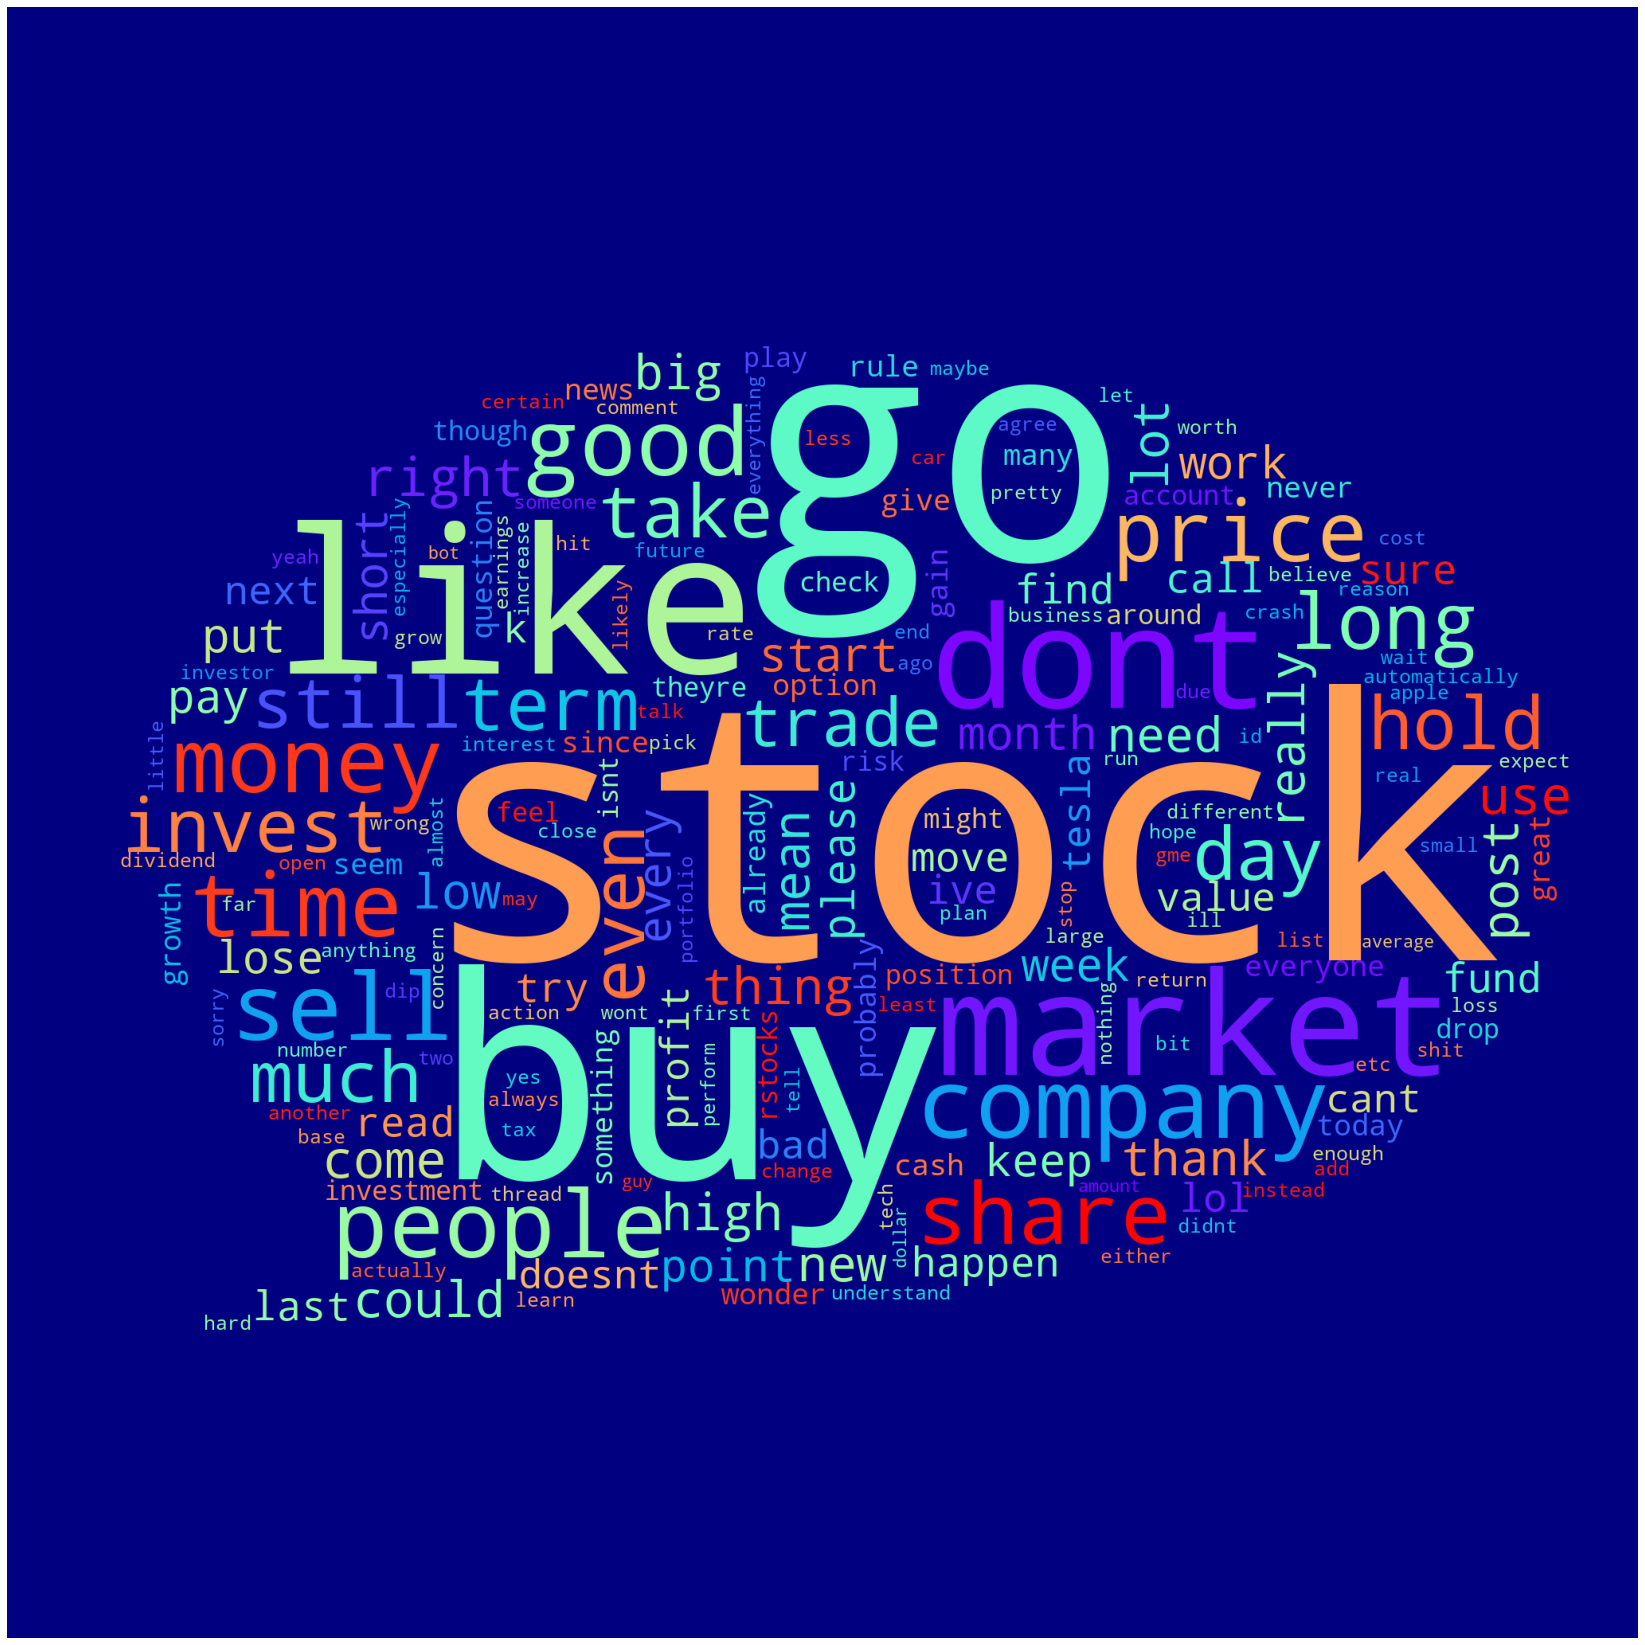

In [47]:
mask = np.array(Image.open('comment.png'))
# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='navy', colormap='rainbow', collocations=False, stopwords = STOPWORDS, mask=mask) \
    .generate_from_frequencies(d)
# Plot
plot_cloud(wordcloud)

In [48]:
wordcloud.to_file("wordcloud1.png")

## 2.2 What is the distribution of text lengths?

In [66]:
text_length_df = corpus.select('features',F.size("features").alias("text_length")). \
    groupBy("text_length"). \
    count().toPandas()

In [118]:
# ! pip install altair
import altair as alt
source = text_length_df
# brush = alt.selection_interval(encodings=["x"])
# color=alt.Color("red")
bar1 = alt.Chart(source).mark_bar().encode(
    x=alt.X("text_length:Q",title="Comment Length",scale=alt.Scale(domain=[0,500]), axis=alt.Axis(grid=False)),
    y=alt.Y("count:Q",title="Count", axis=alt.Axis(grid=False)),
    color=alt.value("#fe4a49"),
    tooltip=alt.Tooltip("count",title='Count')
    # color=alt.condition(brush,alt.value("red"),alt.value('lightgray')),
).properties(
    width=550,
    height=300
).interactive()

alt.vconcat(bar1). \
    configure_title(fontSize=19, align="center", anchor="middle"). \
    configure_axis(labelFontSize=14,titleFontSize=17)



alt.VConcatChart(...)

In [119]:
alt.vconcat(bar1). \
    configure_title(fontSize=19, align="center", anchor="middle"). \
    configure_axis(labelFontSize=14,titleFontSize=17).save("textlength.html")

## 2.3 What are important words according to TF-IDF?

In [26]:
htf = MLHashingTF(inputCol="features", outputCol="tf")
tf = htf.transform(cleaned_df)

In [27]:
idf = MLIDF(inputCol="tf", outputCol="idf")
tfidf = idf.fit(tf).transform(tf)

In [28]:
tfidf.show()

22/05/02 22:51:14 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+------+--------------------+--------------------+--------------------+--------------------+
|doc_id|                text|            features|                  tf|                 idf|
+------+--------------------+--------------------+--------------------+--------------------+
|     0|Nice to read a sa...|[nice, read, sane...|(262144,[16293,22...|(262144,[16293,22...|
|     1|The same type of ...|[type, wall, neve...|(262144,[8145,383...|(262144,[8145,383...|
|     2|Giving a warning ...|[give, warn, win,...|(262144,[18697,62...|(262144,[18697,62...|
|     3|well there's an a...|[article, explain...|(262144,[1097,521...|(262144,[1097,521...|
|     4|Sorry your [submi...|[sorry, submissio...|(262144,[14376,15...|(262144,[14376,15...|
|     5|Making steady gai...|[steady, gain, ti...|(262144,[18697,90...|(262144,[18697,90...|
|     6|Regardless Nvidia...|[regardless, nvid...|(262144,[16004,21...|(262144,[16004,21...|
|     7|           [removed]|                  []|      (262144,[],[])

In [29]:
tfidf = tfidf.withColumnRenamed("idf","tf-idf")

In [30]:
@F.udf("array<Double>")
def extract_values_from_vector_udf(vector):
    return extract_values_from_vector(vector)
def extract_values_from_vector(x):
    return x.values.tolist()

In [31]:
tfidf = tfidf.withColumn("tf-idf-values",extract_values_from_vector_udf("tf-idf"))

In [32]:
tfidf.show()

22/05/02 22:51:15 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|doc_id|                text|            features|                  tf|              tf-idf|       tf-idf-values|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     0|Nice to read a sa...|[nice, read, sane...|(262144,[16293,22...|(262144,[16293,22...|[4.32172719860003...|
|     1|The same type of ...|[type, wall, neve...|(262144,[8145,383...|(262144,[8145,383...|[2.48461848582203...|
|     2|Giving a warning ...|[give, warn, win,...|(262144,[18697,62...|(262144,[18697,62...|[1.97323005309359...|
|     3|well there's an a...|[article, explain...|(262144,[1097,521...|(262144,[1097,521...|[6.69083120968068...|
|     4|Sorry your [submi...|[sorry, submissio...|(262144,[14376,15...|(262144,[14376,15...|[4.07388290193629...|
|     5|Making steady gai...|[steady, gain, ti...|(262144,[18697,90...|(262144,[18697,90

In [33]:
testlist = [5,4,9,2,1]
names = ["a",'B','C','D','R']

@F.udf()
def word_maxidf_udf(tfidfvalue,word):
    return word_maxidf(tfidfvalue,word)
def word_maxidf(tfidfvalues,words):
    if tfidfvalues is None or words is None:
        return ""
    else:
        try:
            maxi = tfidfvalues[0]
            for i in range(len(tfidfvalues)):
                if tfidfvalues[i]>=maxi:
                    maxi = tfidfvalues[i]
                    index = i
            return [words[index],maxi]
        except:
            return ""
word_maxidf(testlist,names)
            
# spark.udf.register("_nullsafeUDF", lambda str: convertCase(str) if not str is None else "" , StringType())

['C', 9]

In [34]:
df_tfidf = tfidf.select("features","tf-idf-values",word_maxidf_udf("tf-idf-values","features").alias("word_biggest_tfidf"))
df_tfidf.show()

22/05/02 22:51:17 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+--------------------+--------------------+--------------------+
|            features|       tf-idf-values|  word_biggest_tfidf|
+--------------------+--------------------+--------------------+
|[nice, read, sane...|[4.32172719860003...|[certainly, 8.684...|
|[type, wall, neve...|[2.48461848582203...|[lie, 7.825731950...|
|[give, warn, win,...|[1.97323005309359...|[warn, 10.8236839...|
|[article, explain...|[6.69083120968068...|[money, 16.055517...|
|[sorry, submissio...|[4.07388290193629...|[check, 13.531734...|
|[steady, gain, ti...|[1.97323005309359...|[sure, 6.51303400...|
|[regardless, nvid...|[3.42078540522675...|[wasnt, 12.145439...|
|                  []|                  []|                    |
|    [trust, squeeze]|[5.37963220422863...|[trust, 5.3796322...|
|[code, open, sour...|[4.65193699128970...|[wouldnt, 12.5509...|
|[like, gravity, p...|[5.53317479647254...|[gravity, 9.04685...|
|[great, potential...|[5.20328311485562...|[potential, 8.656...|
|                  []|   

In [35]:
word_tf=df_tfidf.select("word_biggest_tfidf")

In [36]:
word_tf.show(truncate=False)

22/05/02 22:51:21 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+----------------------------------+
|word_biggest_tfidf                |
+----------------------------------+
|[certainly, 8.684925861736518]    |
|[lie, 7.82573195028047]           |
|[warn, 10.823683980572774]        |
|[money, 16.055517156307513]       |
|[check, 13.531734181674985]       |
|[sure, 6.51303400874112]          |
|[wasnt, 12.145439820555094]       |
|                                  |
|[trust, 5.3796322042286375]       |
|[wouldnt, 12.550904928663257]     |
|[gravity, 9.046850161561395]      |
|[potential, 8.656536858473832]    |
|                                  |
|                                  |
|[unfortunately, 6.364439136187346]|
|[hour, 14.750609889255898]        |
|[gme, 9.183609098676783]          |
|[full, 7.290808774935418]         |
|[less, 7.009641383504832]         |
|[coulda, 9.78866254350143]        |
+----------------------------------+
only showing top 20 rows



In [37]:
test = ["apple",35]


@F.udf()
def list_element_udf(word,position):
    return list_element(word,position)
def list_element(word,position):
    position=int(position)
    if word is None or word=="":
        return ""
    else:
        try:
            return word[position]
        except:
            return ""
list_element(test,1)

35

In [38]:
word_tf = word_tf.dropna()
word_tf.show()

22/05/02 22:51:25 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+--------------------+
|  word_biggest_tfidf|
+--------------------+
|[certainly, 8.684...|
|[lie, 7.825731950...|
|[warn, 10.8236839...|
|[money, 16.055517...|
|[check, 13.531734...|
|[sure, 6.51303400...|
|[wasnt, 12.145439...|
|                    |
|[trust, 5.3796322...|
|[wouldnt, 12.5509...|
|[gravity, 9.04685...|
|[potential, 8.656...|
|                    |
|                    |
|[unfortunately, 6...|
|[hour, 14.7506098...|
|[gme, 9.183609098...|
|[full, 7.29080877...|
|[less, 7.00964138...|
|[coulda, 9.788662...|
+--------------------+
only showing top 20 rows



In [39]:

4
### Drop rows with Null values with where condition in pyspark
 
word_tf = word_tf.where(F.col('word_biggest_tfidf')!='')
word_tf.show()

22/05/02 22:51:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+--------------------+
|  word_biggest_tfidf|
+--------------------+
|[certainly, 8.684...|
|[lie, 7.825731950...|
|[warn, 10.8236839...|
|[money, 16.055517...|
|[check, 13.531734...|
|[sure, 6.51303400...|
|[wasnt, 12.145439...|
|[trust, 5.3796322...|
|[wouldnt, 12.5509...|
|[gravity, 9.04685...|
|[potential, 8.656...|
|[unfortunately, 6...|
|[hour, 14.7506098...|
|[gme, 9.183609098...|
|[full, 7.29080877...|
|[less, 7.00964138...|
|[coulda, 9.788662...|
|[margin, 9.868381...|
|[price, 5.1208649...|
|[strike, 5.813789...|
+--------------------+
only showing top 20 rows



In [40]:
word_tf.printSchema()

root
 |-- word_biggest_tfidf: string (nullable = true)



In [43]:
word_tf = word_tf.withColumn("word_biggest_tfidf",F.split("word_biggest_tfidf",","))

In [44]:
word_tf = word_tf.withColumn("word", word_tf["word_biggest_tfidf"].getItem(0)).withColumn("value", word_tf["word_biggest_tfidf"].getItem(1))

In [45]:
backup=word_tf

In [46]:
word_tf=word_tf.withColumn("word", F.regexp_replace(F.col("word"), "[^a-zA-Z0-9]", "")).withColumn("value", F.regexp_replace(F.col("value"), "\]", ""))

In [47]:
word_tf.printSchema()

root
 |-- word_biggest_tfidf: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- word: string (nullable = true)
 |-- value: string (nullable = true)



In [48]:
word_tf = word_tf.withColumn("value", F.col("value").cast('double')) 

In [49]:
tfidf_rank = word_tf.select("word").groupBy("word").count().orderBy(F.col("count").desc())

In [50]:
tfidf_rank.show()

22/05/02 22:52:21 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/05/02 23:00:50 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+-------+-----+
|   word|count|
+-------+-----+
|    buy|31748|
|  stock|26445|
|     go|25269|
|   like|19541|
|   good|16838|
|  thank|16547|
|   dont|16193|
|   sell|15401|
| market|13900|
| people|11219|
|  share|11218|
|    lol|11189|
|company|11132|
|  money|10980|
|   time|10739|
|   hold| 9693|
|  price| 8910|
|   long| 8851|
| invest| 7978|
|    yes| 7929|
+-------+-----+
only showing top 20 rows



In [51]:
tfidf_rank.write.parquet("s3://zl424-v4/nlp_data/tfidf_rank.parquet", mode="overwrite")  

22/05/02 23:00:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/05/02 23:09:18 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/05/02 23:09:19 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/05/02 23:09:19 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


In [52]:
tf_bar = tfidf_rank.limit(100).toPandas()

22/05/02 23:09:21 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/05/02 23:17:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/05/02 23:17:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


In [120]:
# ! pip install altair
import altair as alt
source = tf_bar.iloc[:20,]
# brush = alt.selection_interval(encodings=["x"])
# color=alt.Color("red")
bar2 = alt.Chart(source).mark_bar().encode(
    x=alt.X("word:O",title="Word",sort="-y", axis=alt.Axis(labelAngle=320)), #,scale=alt.Scale(domain=[0,500])
    y=alt.Y("count:Q",title="TF-IDF-Count", axis=alt.Axis(grid=False)),
    color=alt.value("#6497b1"),
    tooltip=alt.Tooltip("count",title='Count')
    # color=alt.condition(brush,alt.value("red"),alt.value('lightgray')),
).properties(
    width=550,
    height=300
).interactive()

alt.vconcat(bar2). \
    configure_title(fontSize=19, align="center", anchor="middle"). \
    configure_axis(labelFontSize=14,titleFontSize=17)

alt.VConcatChart(...)

In [121]:
alt.vconcat(bar2). \
    configure_title(fontSize=19, align="center", anchor="middle"). \
    configure_axis(labelFontSize=14,titleFontSize=17).save("tfidf.html")

# 3. Create dummy variables.

In [73]:
stocks_comments = df.select("id","mentioned")

In [74]:
df3 = cleaned_df.join(stocks_comments, cleaned_df.doc_id == stocks_comments.id).select(cleaned_df.doc_id, cleaned_df.text,cleaned_df.features,stocks_comments.mentioned)

In [75]:
df4 = df3.select("doc_id","text","features",F.col("mentioned").alias("stocks"),(F.size("mentioned")>0).alias("stocks_mentioned"))

In [76]:
df4.cache()

DataFrame[doc_id: bigint, text: string, features: array<string>, stocks: array<string>, stocks_mentioned: boolean]

In [77]:
df4.show()

22/05/02 23:25:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/02 23:25:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/05/02 23:25:08 WARN DAGScheduler: Broadcasting large task binary with size 2025.4 KiB
22/05/02 23:27:05 WARN DAGScheduler: Broadcasting large task binary with size 2043.8 KiB


+------+--------------------+--------------------+------+----------------+
|doc_id|                text|            features|stocks|stocks_mentioned|
+------+--------------------+--------------------+------+----------------+
|    26|           [removed]|                  []|    []|           false|
|    29|I think you need ...|[need, take, step...|    []|           false|
|   474|Wow did you make ...|         [wow, site]|    []|           false|
|   964|Okay but what sho...|         [okay, buy]|    []|           false|
|  1677|Where are you get...|              [info]|    []|           false|
|  1697|Bc bill Ackerman ...|[bc, bill, ackerm...|    []|           false|
|  1806|Stocks only go up...| [stock, go, though]|    []|           false|
|  1950|Regret isn’t gonn...|[regret, isnt, go...|    []|           false|
|  2040|Sorry your [submi...|[sorry, submissio...|    []|           false|
|  2214|if GME continues ...|[gme, continue, g...| [GME]|            true|
|  2250|             Exac

# 4. Sentiment Analysis of Top 20 stocks mentioned

In [78]:
#MODEL_NAME='sentimentdl_use_imdb'
MODEL_NAME='sentimentdl_use_twitter'

In [79]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name=MODEL_NAME, lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ | ]tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ | ]Download done! Loading the resource.
[ / ]

2022-05-02 23:27:40.124202: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-02 23:27:40.562331: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


[ \ ]

2022-05-02 23:27:45.362451: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.
2022-05-02 23:27:45.450990: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.
2022-05-02 23:27:45.522428: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.
2022-05-02 23:27:45.577209: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.
2022-05-02 23:27:45.619909: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.


[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[ | ]sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[ / ]Download done! Loading the resource.
[OK!]


In [80]:
empty_df = spark.createDataFrame([['']]).toDF("text")
pipelineModel = nlpPipeline.fit(empty_df)
result = pipelineModel.transform(df4)

In [81]:
result.show(5)

22/05/02 23:27:57 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


+------+--------------------+--------------------+------+----------------+--------------------+--------------------+--------------------+
|doc_id|                text|            features|stocks|stocks_mentioned|            document| sentence_embeddings|           sentiment|
+------+--------------------+--------------------+------+----------------+--------------------+--------------------+--------------------+
|    26|           [removed]|                  []|    []|           false|[[document, 0, 8,...|[[sentence_embedd...|[[category, 0, 8,...|
|    29|I think you need ...|[need, take, step...|    []|           false|[[document, 0, 12...|[[sentence_embedd...|[[category, 0, 12...|
|   474|Wow did you make ...|         [wow, site]|    []|           false|[[document, 0, 42...|[[sentence_embedd...|[[category, 0, 42...|
|   964|Okay but what sho...|         [okay, buy]|    []|           false|[[document, 0, 34...|[[sentence_embedd...|[[category, 0, 34...|
|  1677|Where are you get...|     

In [82]:
result.count()

22/05/02 23:28:14 WARN DAGScheduler: Broadcasting large task binary with size 2042.0 KiB


2258804

In [83]:
sa = result.select("doc_id","text","stocks","stocks_mentioned",F.explode_outer('sentiment.result').alias("sentiment"))

In [84]:
top20 = sa.filter(F.col("stocks_mentioned")=="true").select(F.explode("stocks").alias("stocks"),"sentiment"). \
    groupBy("stocks").count(). \
    sort("count", ascending=False).limit(20)
top20pd=top20.toPandas()
top20names=top20pd.stocks.tolist()

22/05/02 23:28:17 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/05/02 23:29:12 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/05/02 23:29:12 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


In [85]:
@F.udf()
def top20name(col):
    if col in top20names:
        return "true"
    else:
        return "false"

In [86]:
sa = sa.select("doc_id","text",F.explode_outer("stocks").alias("stocks"),"stocks_mentioned","sentiment")

In [87]:
sa = sa.withColumn("Top20_mentioned",top20name(F.col("stocks")))

In [88]:
sa.show(10)

22/05/02 23:29:12 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


+------+--------------------+------+----------------+---------+---------------+
|doc_id|                text|stocks|stocks_mentioned|sentiment|Top20_mentioned|
+------+--------------------+------+----------------+---------+---------------+
|    26|           [removed]|  null|           false| negative|          false|
|    29|I think you need ...|  null|           false| positive|          false|
|   474|Wow did you make ...|  null|           false| positive|          false|
|   964|Okay but what sho...|  null|           false| negative|          false|
|  1677|Where are you get...|  null|           false| positive|          false|
|  1697|Bc bill Ackerman ...|  null|           false| negative|          false|
|  1806|Stocks only go up...|  null|           false| negative|          false|
|  1950|Regret isn’t gonn...|  null|           false| positive|          false|
|  2040|Sorry your [submi...|  null|           false| positive|          false|
|  2214|if GME continues ...|   GME|    

In [89]:
analytical_sa = sa.filter(F.col("Top20_mentioned")=="true"). \
    select("doc_id","stocks","sentiment"). \
    groupBy("stocks","sentiment"). \
    count().\
    sort("stocks","sentiment","count",ascending=False)

In [90]:
analytical_sa.show()

22/05/02 23:29:50 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/05/02 23:33:17 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


+------+---------+-----+
|stocks|sentiment|count|
+------+---------+-----+
|  TSLA| positive| 9537|
|  TSLA|  neutral|  522|
|  TSLA| negative| 4732|
|    TD| positive| 2421|
|    TD|  neutral|  112|
|    TD| negative| 1813|
|    SQ| positive| 3291|
|    SQ|  neutral|  211|
|    SQ| negative| 1154|
|    RH| positive| 2354|
|    RH|  neutral|  164|
|    RH| negative| 3071|
|  PLTR| positive| 5272|
|  PLTR|  neutral|  612|
|  PLTR| negative| 2866|
|    OP| positive| 6556|
|    OP|  neutral|  251|
|    OP| negative| 1718|
|  NVDA| positive| 2853|
|  NVDA|  neutral|  137|
+------+---------+-----+
only showing top 20 rows



In [91]:
analytical_sa.write.parquet("s3://zl424-v4/nlp_data/analytical_sa.parquet", mode="overwrite")  

22/05/02 23:33:35 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/05/02 23:37:06 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/05/02 23:37:06 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/05/02 23:37:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


In [92]:
p1 = analytical_sa.toPandas()

22/05/02 23:37:08 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/05/02 23:40:43 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/05/02 23:40:43 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/05/02 23:40:43 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


In [93]:
p1.sort_values(by=["stocks","sentiment","count"],ascending=False).head(12)

,stocks,sentiment,count
0,TSLA,positive,9537
1,TSLA,neutral,522
2,TSLA,negative,4732
3,TD,positive,2421
4,TD,neutral,112
5,TD,negative,1813
6,SQ,positive,3291
7,SQ,neutral,211
8,SQ,negative,1154
9,RH,positive,2354


In [152]:
import altair as alt
source = p1
scale=alt.Scale(domain=['positive', 'neutral', 'negative'], range=['#7bc043', '#fdf498', '#ee4035'])
color=alt.Color("sentiment:N",scale=scale)
bar3 = alt.Chart(source).mark_bar(
    cornerRadiusTopLeft=3,
    cornerRadiusTopRight=3
).encode(
    x=alt.X('stocks:N',title="Stocks",sort="-y",axis=alt.Axis(labelAngle=320)),
    y=alt.Y('count:Q',title="Count",axis=alt.Axis(grid=False)),
    color=color
).properties(
    width=550,
    height=300
    # title="Sentiment results of Top20 stocks mentioned in Reddit (r/stocks)"
)
alt.vconcat(bar3). \
    configure_title(fontSize=19, align="center", anchor="middle"). \
    configure_legend(titleColor='black', labelFontSize=17, titleFontSize=17). \
    configure_axis(labelFontSize=14,titleFontSize=17)

NameError: name 'p1' is not defined

In [123]:
alt.vconcat(bar3). \
    configure_title(fontSize=19, align="center", anchor="middle"). \
    configure_legend(titleColor='black', labelFontSize=17, titleFontSize=17). \
    configure_axis(labelFontSize=14,titleFontSize=17).save("top20sentiments.html")

# 6. Bull/Bear market trend analysis

In [117]:
comment_time = df.select("id","comment_created_date")

In [118]:
sa.printSchema()

root
 |-- doc_id: long (nullable = false)
 |-- text: string (nullable = false)
 |-- stocks: string (nullable = true)
 |-- stocks_mentioned: boolean (nullable = false)
 |-- sentiment: string (nullable = true)
 |-- Top20_mentioned: string (nullable = true)



In [149]:
df5 = sa.join(comment_time, sa.doc_id == comment_time.id). \
    select(sa.doc_id, comment_time.comment_created_date, sa.text, sa.stocks, sa.stocks_mentioned, sa.Top20_mentioned, sa.sentiment)

In [150]:
df5.show()

22/04/16 23:39:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/04/16 23:39:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/04/16 23:39:07 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/16 23:41:36 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


+------+--------------------+--------------------+------+----------------+---------------+---------+
|doc_id|comment_created_date|                text|stocks|stocks_mentioned|Top20_mentioned|sentiment|
+------+--------------------+--------------------+------+----------------+---------------+---------+
|    25| 2021-02-25 14:29:10|Yeah for sure dur...|  null|           false|          false| positive|
|    65| 2021-02-05 15:59:05|           [removed]|  null|           false|          false| negative|
|    77| 2021-02-10 15:39:24|           [removed]|  null|           false|          false| negative|
|    94| 2021-02-02 15:54:21|It’s hard to resi...|  null|           false|          false| positive|
|   124| 2021-02-24 22:18:25|Why would it be?
...|  null|           false|          false| negative|
|   149| 2021-02-06 13:47:05|           [removed]|  null|           false|          false| negative|
|   181| 2021-02-08 22:44:27|Spoiler tags dude...|  null|           false|          false| 

In [151]:
df5.groupBy("sentiment").count().show()

+---------+-------+
|sentiment|  count|
+---------+-------+
| positive|1185699|
|     null|    217|
|  neutral| 102458|
| negative| 834017|
+---------+-------+



In [7]:
df5 = spark.read.parquet("s3://zl424-v4/df5.parquet/")

In [8]:
from pyspark.sql.functions import when
market_df = df5.withColumn("sentiment", when(df5.sentiment == "positive",1)
                                 .when(df5.sentiment == "negative",-1)
                                 .when(df5.sentiment == "neutral",0)
                                 .otherwise(""))

## bull/bear market trend

In [9]:
p2 = market_df.toPandas()

In [10]:
import datetime
p2['day'] = pd.to_datetime(p2['comment_created_date']).dt.to_period('D')

In [12]:
p2 = p2.loc[(p2.sentiment=="1") | (p2.sentiment=="-1") | (p2.sentiment=='0'),]

In [13]:
p2["sentiment"] = p2["sentiment"].astype(float)

/mnt/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2122174 entries, 0 to 2122390
Data columns (total 8 columns):
 #   Column                Dtype    
---  ------                -----    
 0   doc_id                int64    
 1   comment_created_date  object   
 2   text                  object   
 3   stocks                object   
 4   stocks_mentioned      bool     
 5   Top20_mentioned       object   
 6   sentiment             float64  
 7   day                   period[D]
dtypes: bool(1), float64(1), int64(1), object(4), period[D](1)
memory usage: 131.6+ MB


In [20]:
p2['day'] = p2['day'].astype(str)

/mnt/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
p2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2122174 entries, 0 to 2122390
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   doc_id                int64  
 1   comment_created_date  object 
 2   text                  object 
 3   stocks                object 
 4   stocks_mentioned      bool   
 5   Top20_mentioned       object 
 6   sentiment             float64
 7   day                   object 
dtypes: bool(1), float64(1), int64(1), object(5)
memory usage: 131.6+ MB


In [22]:
summary2 = p2.groupby(by=['day'],as_index=False).\
    agg({'sentiment':"sum"}).\
    sort_values(by='day',ascending=False).\
    reset_index().\
    drop("index",axis=1)

In [23]:
summary2.sentiment

,day,sentiment
0,2021-06-30,165.0
1,2021-06-29,84.0
2,2021-06-28,80.0
3,2021-06-27,33.0
4,2021-06-26,73.0
...,...,...
724,2019-07-05,73.0
725,2019-07-04,76.0
726,2019-07-03,140.0
727,2019-07-02,90.0


In [150]:
import altair as alt
source = summary2
base = alt.Chart(source).properties(width=550)
# scale=alt.Scale(domain=['bear', "bull"], range=['#ee4035','#7bc043'])
# color=alt.Color("weather:N",scale=scale)
line = base.mark_line().encode(
    x=alt.X('day:T',title="Time", axis=alt.Axis(labelAngle=320,grid=False)),
    y=alt.Y('sentiment:Q',title="Sentiment Values",axis=alt.Axis(grid=False)),
    # color=alt.condition(
    #     alt.datum.sentiment > 500,
    #     alt.value("green"),  # The positive color
    #     alt.value("red")  # The negative color
    # )
).properties(
    width=550,
    height=300,
    # title="Bull / Bear market analysis based on comments' sentiment in Reddit (r/stocks)"
)

xrule = base.mark_rule().encode(
    y='average(sentiment)',
    color=alt.value("red"),
    size=alt.value(2)
)
alt.vconcat(line+rule). \
    configure_title(fontSize=19, align="center", anchor="middle"). \
    configure_axis(labelFontSize=11,titleFontSize=17)

alt.VConcatChart(...)

In [151]:
alt.vconcat(line+rule). \
    configure_title(fontSize=19, align="center", anchor="middle"). \
    configure_axis(labelFontSize=11,titleFontSize=17).save("overbull.html")

## Sentiment Time-series analysis for Top20 stocks mentioned 

In [48]:
p3 = p2.loc[p2.Top20_mentioned=="true",]

In [49]:
summary3 = p3.groupby(by=["stocks",'day'],as_index=False).\
    agg({'sentiment':"sum"}).\
    sort_values(by=["stocks",'day'],ascending=False).\
    reset_index().\
    drop("index",axis=1)

In [50]:
summary3

,stocks,day,sentiment
0,TSLA,2021-06-30,1.0
1,TSLA,2021-06-29,-1.0
2,TSLA,2021-06-28,4.0
3,TSLA,2021-06-27,2.0
4,TSLA,2021-06-26,0.0
...,...,...,...
13314,AAPL,2019-07-05,2.0
13315,AAPL,2019-07-04,-1.0
13316,AAPL,2019-07-03,4.0
13317,AAPL,2019-07-02,2.0


In [54]:
summary3.stocks.unique().tolist()

['TSLA',
 'TD',
 'SQ',
 'RH',
 'PLTR',
 'OP',
 'NVDA',
 'NIO',
 'MSFT',
 'IMO',
 'GME',
 'FB',
 'DIS',
 'DD',
 'BB',
 'BABA',
 'AMZN',
 'AMD',
 'AMC',
 'AAPL']

In [148]:
import altair as alt
alt.data_transformers.disable_max_rows()
source = summary3
base = alt.Chart(source).properties(width=550)
scale=alt.Scale(domain=source.stocks.unique().tolist())
color=alt.Color("stocks:N",scale=scale) #
click = alt.selection_multi(fields=["stocks"])
# scale=alt.Scale(domain=['bear', "bull"], range=['#ee4035','#7bc043'])
# color=alt.Color("weather:N",scale=scale)
line = base.mark_line().encode(
    x=alt.X('day:T',title="Time", axis=alt.Axis(labelAngle=320,grid=False)),
    y=alt.Y('sentiment:Q',title="Sentiment Values",axis=alt.Axis(grid=False)),
    # color="stocks"
    color=alt.condition(click,color,alt.value("lightgray"))
    # color=alt.condition(alt.value('#ee4035'),alt.value('#7bc043'))
).properties(
    width=550,
    height=300,
    # title="Bull / Bear market analysis based on comments' sentiment in Reddit (r/stocks)"
).add_selection(click)


# rule = base.mark_rule().encode(
#     y='average(sentiment)',
#     color="stocks",
#     size=alt.value(2)
# )
alt.vconcat(line). \
    configure_title(fontSize=19, align="center", anchor="middle"). \
    configure_legend(titleColor='black', labelFontSize=17, titleFontSize=17). \
    configure_axis(labelFontSize=11,titleFontSize=17)

alt.VConcatChart(...)

In [149]:
alt.vconcat(line). \
    configure_title(fontSize=19, align="center", anchor="middle"). \
    configure_legend(titleColor='black', labelFontSize=17, titleFontSize=17). \
    configure_axis(labelFontSize=11,titleFontSize=17).save("complex20.html")

In [76]:
tesla = spark.read.csv("s3://zl424-v4/Tesla_stock.csv",header=True)

In [77]:
tesla = tesla.withColumn("Close/Last", F.regexp_replace(F.col("Close/Last"), "\$", ""))

In [78]:
te = tesla.select("Date","Close/Last").toPandas()

In [79]:
te["Close/Last"] = te["Close/Last"].astype(float)

In [80]:
te["Date"] = pd.to_datetime(te["Date"],format='%m/%d/%Y')

# p2['month_year'] = pd.to_datetime(p2['comment_created_date']).dt.to_period('M')

In [73]:
te_sentiment=summary3[summary3["stocks"]=="TSLA"]

In [88]:
te_sentiment = te_sentiment.rename(columns={"day": "Date"})

In [85]:
te = te[te["Date"]>="2019-07-01"]

In [94]:
te['Date'] = te['Date'].astype(str)

/mnt/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [95]:
te_plot=pd.merge(te_sentiment,te,on='Date')

In [118]:
bb=te_plot

In [119]:
te_plot["sentiment"] = te_plot["sentiment"]/te_plot["sentiment"].abs().max()

In [120]:
te_plot["Close/Last"] = te_plot["Close/Last"]/te_plot["Close/Last"].abs().max()

In [146]:
import altair as alt
source = te_plot
base = alt.Chart(source).properties(width=550)

base = alt.Chart(source).encode(
    x=alt.X('Date:T',title="Time", axis=alt.Axis(labelAngle=320,grid=False))
)

line1 = base.mark_line().encode(
    y=alt.Y('Close/Last:Q',axis=alt.Axis(title="Standardized Stock Price", titleColor='#00aedb', grid=False),scale=alt.Scale(domain=[-0.1,1.1])),
    color=alt.value("#00aedb")
).properties(
    width=550,
    height=300,
).interactive()


line2 = base.mark_line().encode(
    y=alt.Y('sentiment:Q',axis=alt.Axis(title="Standardized Sentiment Value", titleColor='#d11141',grid=False),scale=alt.Scale(domain=[-0.1,1.1])),
    color=alt.value("#d11141")
).properties(
    width=550,
    height=300,
).interactive()

alt.layer(line1, line2). \
    resolve_scale(y = 'independent').\
    configure_title(fontSize=19, align="center", anchor="middle"). \
    configure_legend(titleColor='black', labelFontSize=17, titleFontSize=17). \
    configure_axis(labelFontSize=11,titleFontSize=17)


alt.LayerChart(...)

In [147]:
alt.vconcat(line). \
    configure_title(fontSize=19, align="center", anchor="middle"). \
    configure_legend(titleColor='black', labelFontSize=17, titleFontSize=17). \
    configure_axis(labelFontSize=11,titleFontSize=17).save("nlp_tesla.html")

# 7. Save dataset into S3

In [264]:
df3.write.parquet("s3://zl424-v3/nlp_data/df3.parquet", mode="overwrite")   

In [265]:
df4.write.parquet("s3://zl424-v3/nlp_data/df4.parquet", mode="overwrite")   

In [266]:
df5.write.parquet("s3://zl424-v3/nlp_data/df5.parquet", mode="overwrite")   

22/04/17 00:33:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/04/17 00:33:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/04/17 00:33:12 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/17 00:35:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


In [ ]:
spark.stop()